In [1]:
! pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 27.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 16.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, Subset, ConcatDataset
from sklearn.metrics import classification_report, f1_score
from torchvision import transforms
from datasets import load_dataset
from collections import Counter
from transformers import AutoTokenizer
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [3]:
class FashionMNISTDataset(Dataset):
    def __init__(self, split='train', augment=False):
        self.dataset = load_dataset('fashion_mnist')[split]

        # Transformação básica
        self.base_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))
        ])

        # Aumento de dados
        self.augment_transform = transforms.Compose([
            transforms.RandomRotation(10),
            transforms.RandomHorizontalFlip(),
            transforms.RandomResizedCrop(28, scale=(0.8, 1.0)),
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))
        ]) if augment else None

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        image = item['image']
        label = item['label']

        # Escolhe aleatoriamente se aplica ou não augmentação
        if self.augment_transform and torch.rand(1).item() > 0.5:
            image = self.augment_transform(image)
        else:
            image = self.base_transform(image)

        return {
            'image': image,
            'label': torch.tensor(label, dtype=torch.long)
        }

# Criando o dataset original e um dataset aumentado
dataset_original = FashionMNISTDataset(split='train', augment=False)
dataset_aumentado = FashionMNISTDataset(split='train', augment=True)

# Concatenando os dois para dobrar o número de dados
dataset_final = ConcatDataset([dataset_original, dataset_aumentado])




/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/9.02k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/30.9M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/5.18M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [4]:
class FashionMNISTClassifier_CNN(nn.Module):
    def __init__(self,
                 num_classes=10,
                 dropout=0.5,
                 filters=[32, 64, 128, 256, 512],
                 kernel_size=3):
        super().__init__()

        # Camadas convolucionais
        self.conv1 = nn.Conv2d(in_channels=1, out_channels = filters[0], kernel_size=kernel_size, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels = filters[0], out_channels = filters[1], kernel_size=kernel_size, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels = filters[1], out_channels = filters[2], kernel_size=kernel_size, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels = filters[2], out_channels = filters[3], kernel_size=kernel_size, stride=1, padding=1)
        self.conv5 = nn.Conv2d(in_channels = filters[3], out_channels = filters[4], kernel_size=kernel_size, stride=1, padding=1)

        # Pooling
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Ativação
        self.act = nn.LeakyReLU(0.1)

        # Dropout
        self.dropout = nn.Dropout(dropout)

        # Flatten
        self.flatten = nn.Flatten()

        # Camadas densas
        self.dense1 = nn.Linear(in_features=filters[4] * 14 * 14, out_features=512)
        self.dense2 = nn.Linear(in_features=512, out_features=num_classes)

        # Normalização
        self.layer_norm_conv1 = nn.LayerNorm((filters[0], 28, 28))
        self.layer_norm_conv2 = nn.LayerNorm((filters[1], 14, 14))
        self.layer_norm_conv3 = nn.LayerNorm((filters[2], 14, 14))
        self.layer_norm_conv4 = nn.LayerNorm((filters[3], 14, 14))
        self.layer_norm_conv5 = nn.LayerNorm((filters[4], 14, 14))
        self.layer_norm_dense1 = nn.LayerNorm(filters[4])

    def forward(self, x):
        # Primeira camada convolucional
        x = self.conv1(x)  # [B, 32, 28, 28]
        x = self.layer_norm_conv1(x)
        x = self.pool(x)   # [B, 32, 14, 14]
        x = self.act(x)
        x = self.dropout(x)

        # Segunda camada convolucional
        x = self.conv2(x)  # [B, 64, 14, 14]
        x = self.layer_norm_conv2(x)
        x = self.act(x)
        x = self.dropout(x)

        # Terceira camada convolucional
        x = self.conv3(x)  # [B, 128, 14, 14]
        x = self.layer_norm_conv3(x)
        x = self.act(x)
        x = self.dropout(x)

        # Quarta camada convolucional
        x = self.conv4(x)  # [B, 256, 14, 14]
        x = self.layer_norm_conv4(x)
        x = self.act(x)
        x = self.dropout(x)

        # Quinta camada convolucional
        x = self.conv5(x)  # [B, 512, 14, 14]
        x = self.layer_norm_conv5(x)
        x = self.act(x)
        x = self.dropout(x)

        # Flatten
        x = self.flatten(x)  # [B, 512*14*14]

        # Primeira camada densa
        x = self.dense1(x)  # [B, 512]
        x = self.layer_norm_dense1(x)
        x = self.act(x)
        x = self.dropout(x)

        # Segunda camada densa
        x = self.dense2(x)  # [B, num_classes]

        return x


In [5]:
def train_model(model,
                train_loader,
                valid_loader,
                criterion,
                optimizer,
                n_epochs,
                device,
                patience):

    best_valid_loss = float('inf')
    epochs_no_improve = 0

    history = {
        'train_loss': [],
        'train_acc': [],
        'valid_loss': [],
        'valid_acc': []
    }

    for epoch in range(n_epochs):

        model.train()
        train_loss = 0
        train_correct = 0
        total_train = 0

        for batch in tqdm(train_loader, total=len(train_loader)):

            # Carregar dados
            images = batch['image'].to(device)
            labels = batch['label'].to(device)

            # Forward
            optimizer.zero_grad()
            predictions = model(images)

            # Calcular perda
            loss = criterion(predictions, labels)

            # Backward e otimização
            loss.backward()
            optimizer.step()

            # Métricas de treino
            train_loss += loss.item()
            preds = torch.argmax(predictions, dim=1)
            train_correct += (preds == labels).sum().item()
            total_train += labels.size(0)

        # Calcular média de perda e acurácia no treino
        train_loss /= len(train_loader)
        train_acc = train_correct / total_train

        # Validação
        model.eval()
        valid_loss = 0
        valid_correct = 0
        total_valid = 0

        with torch.no_grad():
            for batch in tqdm(valid_loader, total=len(valid_loader), desc='Running validation...'):
                images = batch['image'].to(device)
                labels = batch['label'].to(device)

                predictions = model(images)
                loss = criterion(predictions, labels)

                # Métricas de validação
                valid_loss += loss.item()
                preds = torch.argmax(predictions, dim=1)
                valid_correct += (preds == labels).sum().item()
                total_valid += labels.size(0)

        # Calcular média de perda e acurácia na validação
        valid_loss /= len(valid_loader)
        valid_acc = valid_correct / total_valid

        # Histórico
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['valid_loss'].append(valid_loss)
        history['valid_acc'].append(valid_acc)

        print(f'Epoch {epoch+1}/{n_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, '
              f'Valid Loss: {valid_loss:.4f}, Valid Acc: {valid_acc:.4f}')

        # Early stopping
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), 'fashion_mnist_model.pt')
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve == patience:
            print('Early stopping!')
            break

    return history


def test_model(model, test_loader, device):
    model.eval()
    test_loss = 0
    test_correct = 0
    total_test = 0

    predictions_all = []
    labels_all = []

    with torch.no_grad():
        for batch in tqdm(test_loader, total=len(test_loader), desc='Running test...'):
            images = batch['image'].to(device)
            labels = batch['label'].to(device)

            # Forward
            predictions = model(images)
            loss = criterion(predictions, labels)

            # Armazenar previsões e rótulos
            predictions_all.append(torch.argmax(predictions, dim=1))
            labels_all.append(labels)

            # Métricas de teste
            test_loss += loss.item()
            test_correct += (torch.argmax(predictions, dim=1) == labels).sum().item()
            total_test += labels.size(0)

    # Calcular médias
    test_loss /= len(test_loader)
    test_acc = test_correct / total_test

    print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')

    # Concatenar todas as previsões e rótulos para análise posterior
    y_pred = torch.cat(predictions_all, dim=0)
    y_test = torch.cat(labels_all, dim=0)

    return test_loss, test_acc, y_pred, y_test



In [6]:
def make_plots(history):

    # losses
    loss_values = history['train_loss']
    val_loss_values = history['valid_loss']

    # accuracies
    acc_values = history['train_acc']
    val_acc_values = history['valid_acc']

    epochs = range(len(acc_values))

    fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8,8))

    ax1.plot(epochs, loss_values, 'bo', label="Training Loss")
    ax1.plot(epochs, val_loss_values, 'b', label="Validation Loss")
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss Value')
    ax1.legend()

    ax2.plot(epochs, acc_values, 'ro', label="Training Accuracy")
    ax2.plot(epochs, val_acc_values, 'r', label="Validation Accuracy")
    ax2.set_title('Training and Validation Accuraccy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend()

In [7]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [8]:
# Criando Datasets de treino
train_dataset_1 = FashionMNISTDataset('train', augment = True)
train_dataset_2 = FashionMNISTDataset('train', augment = False)

# Concatenando os dois para dobrar o número de dados
train_dataset = ConcatDataset([train_dataset_1, train_dataset_2])

# Dataset de teste
test_dataset = FashionMNISTDataset('test', augment = False)

print(f"Tamanho do treino original: {len(train_dataset_2)}")
print(f"Tamanho do treino aumentado: {len(train_dataset)}")
print(f"Tamanho do teste(sem dividir em validação): {len(test_dataset)}")

Tamanho do treino original: 60000
Tamanho do treino aumentado: 120000
Tamanho do teste(sem dividir em validação): 10000


In [9]:
# entradas
indices = list(range(len(test_dataset)))

# divisão
valid_indices, test_indices = train_test_split(indices,
                                               test_size=0.5,
                                               stratify=[test_dataset[i]['label'] for i in indices]
                                              )

# coleta subsets
valid_dataset = Subset(test_dataset, valid_indices)
test_dataset = Subset(test_dataset, test_indices)

In [10]:
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

In [11]:
# Initialize model dropout=0.5,  kernel_size=3
model = FashionMNISTClassifier_CNN(
        num_classes=10,
        dropout=0.5,
        filters=[32, 64, 128, 256, 512],
        kernel_size = 3
    ).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr = 1e-4, weight_decay = 1e-2, betas = (0.9, 0.98))

In [12]:
def forward_model(model,
                  loader,
                  device):

    # Definir o modelo em modo de avaliação
    model.eval()

    i = 0
    for batch in tqdm(loader, total=len(loader), desc='Running validation...'):
        # Obter imagens e labels
        images = batch['image'].to(device)
        labels = batch['label'].to(device)

        # Fazer previsões
        predictions = model(images)

        # Log da saída para análise
        print(f'Predictions shape: {predictions.shape}')  # Verifica a forma da saída

        # Limitar a iteração (apenas 10 batches)
        if i == 10:
            return
        i += 1


In [13]:
model

FashionMNISTClassifier_CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (act): LeakyReLU(negative_slope=0.1)
  (dropout): Dropout(p=0.5, inplace=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dense1): Linear(in_features=100352, out_features=512, bias=True)
  (dense2): Linear(in_features=512, out_features=10, bias=True)
  (layer_norm_conv1): LayerNorm((32, 28, 28), eps=1e-05, elementwise_affine=True)
  (layer_norm_conv2): LayerNorm((64, 14, 14), eps=1e-05, elementwise_affine=True)
  (layer_norm_conv3): LayerNorm((128, 14, 14), eps=1e-05, elementwise_affi

In [14]:
forward_model(model, train_loader, device=device)

Running validation...:   0%|          | 4/1875 [00:00<05:46,  5.41it/s]

Predictions shape: torch.Size([64, 10])
Predictions shape: torch.Size([64, 10])
Predictions shape: torch.Size([64, 10])
Predictions shape: torch.Size([64, 10])
Predictions shape: torch.Size([64, 10])
Predictions shape: torch.Size([64, 10])


Running validation...:   1%|          | 10/1875 [00:01<03:40,  8.48it/s]

Predictions shape: torch.Size([64, 10])
Predictions shape: torch.Size([64, 10])
Predictions shape: torch.Size([64, 10])
Predictions shape: torch.Size([64, 10])
Predictions shape: torch.Size([64, 10])


In [15]:
# Train the model
history = train_model(model, train_loader, valid_loader, criterion, optimizer, n_epochs=75, device=device, patience = 7)

Running validation...: 100%|██████████| 157/157 [00:03<00:00, 46.63it/s]


Epoch 1/75, Train Loss: 0.6255, Train Acc: 0.7723, Valid Loss: 0.3809, Valid Acc: 0.8620


Running validation...: 100%|██████████| 157/157 [00:03<00:00, 40.19it/s]


Epoch 2/75, Train Loss: 0.4274, Train Acc: 0.8423, Valid Loss: 0.3308, Valid Acc: 0.8776


Running validation...: 100%|██████████| 157/157 [00:02<00:00, 52.62it/s]


Epoch 3/75, Train Loss: 0.3788, Train Acc: 0.8592, Valid Loss: 0.2930, Valid Acc: 0.8912


Running validation...: 100%|██████████| 157/157 [00:02<00:00, 53.03it/s]


Epoch 4/75, Train Loss: 0.3471, Train Acc: 0.8709, Valid Loss: 0.2752, Valid Acc: 0.8974


Running validation...: 100%|██████████| 157/157 [00:03<00:00, 50.09it/s]


Epoch 5/75, Train Loss: 0.3277, Train Acc: 0.8787, Valid Loss: 0.2704, Valid Acc: 0.9006


Running validation...: 100%|██████████| 157/157 [00:02<00:00, 53.57it/s]


Epoch 6/75, Train Loss: 0.3132, Train Acc: 0.8843, Valid Loss: 0.2630, Valid Acc: 0.9042


Running validation...: 100%|██████████| 157/157 [00:02<00:00, 52.34it/s]


Epoch 7/75, Train Loss: 0.3000, Train Acc: 0.8886, Valid Loss: 0.2490, Valid Acc: 0.9090


Running validation...: 100%|██████████| 157/157 [00:03<00:00, 51.33it/s]


Epoch 8/75, Train Loss: 0.2898, Train Acc: 0.8932, Valid Loss: 0.2342, Valid Acc: 0.9152


Running validation...: 100%|██████████| 157/157 [00:02<00:00, 52.59it/s]


Epoch 9/75, Train Loss: 0.2807, Train Acc: 0.8962, Valid Loss: 0.2372, Valid Acc: 0.9108


Running validation...: 100%|██████████| 157/157 [00:02<00:00, 53.97it/s]


Epoch 10/75, Train Loss: 0.2734, Train Acc: 0.8987, Valid Loss: 0.2307, Valid Acc: 0.9142


Running validation...: 100%|██████████| 157/157 [00:03<00:00, 43.96it/s]


Epoch 11/75, Train Loss: 0.2681, Train Acc: 0.9019, Valid Loss: 0.2252, Valid Acc: 0.9184


Running validation...: 100%|██████████| 157/157 [00:02<00:00, 53.18it/s]


Epoch 12/75, Train Loss: 0.2621, Train Acc: 0.9024, Valid Loss: 0.2201, Valid Acc: 0.9206


Running validation...: 100%|██████████| 157/157 [00:02<00:00, 54.39it/s]


Epoch 13/75, Train Loss: 0.2560, Train Acc: 0.9052, Valid Loss: 0.2213, Valid Acc: 0.9206


Running validation...: 100%|██████████| 157/157 [00:03<00:00, 43.96it/s]


Epoch 14/75, Train Loss: 0.2511, Train Acc: 0.9071, Valid Loss: 0.2160, Valid Acc: 0.9234


Running validation...: 100%|██████████| 157/157 [00:02<00:00, 53.71it/s]


Epoch 15/75, Train Loss: 0.2453, Train Acc: 0.9079, Valid Loss: 0.2148, Valid Acc: 0.9200


Running validation...: 100%|██████████| 157/157 [00:03<00:00, 45.21it/s]


Epoch 16/75, Train Loss: 0.2421, Train Acc: 0.9098, Valid Loss: 0.2170, Valid Acc: 0.9198


Running validation...: 100%|██████████| 157/157 [00:03<00:00, 52.26it/s]


Epoch 17/75, Train Loss: 0.2375, Train Acc: 0.9120, Valid Loss: 0.2163, Valid Acc: 0.9244


Running validation...: 100%|██████████| 157/157 [00:03<00:00, 43.71it/s]


Epoch 18/75, Train Loss: 0.2353, Train Acc: 0.9126, Valid Loss: 0.2040, Valid Acc: 0.9262


Running validation...: 100%|██████████| 157/157 [00:02<00:00, 53.97it/s]


Epoch 19/75, Train Loss: 0.2317, Train Acc: 0.9140, Valid Loss: 0.2096, Valid Acc: 0.9240


Running validation...: 100%|██████████| 157/157 [00:02<00:00, 52.67it/s]


Epoch 20/75, Train Loss: 0.2260, Train Acc: 0.9164, Valid Loss: 0.2096, Valid Acc: 0.9246


Running validation...: 100%|██████████| 157/157 [00:03<00:00, 42.74it/s]


Epoch 21/75, Train Loss: 0.2254, Train Acc: 0.9163, Valid Loss: 0.2084, Valid Acc: 0.9234


Running validation...: 100%|██████████| 157/157 [00:02<00:00, 53.57it/s]


Epoch 22/75, Train Loss: 0.2230, Train Acc: 0.9178, Valid Loss: 0.2054, Valid Acc: 0.9220


Running validation...: 100%|██████████| 157/157 [00:02<00:00, 53.44it/s]


Epoch 23/75, Train Loss: 0.2182, Train Acc: 0.9191, Valid Loss: 0.2061, Valid Acc: 0.9244


Running validation...: 100%|██████████| 157/157 [00:04<00:00, 35.66it/s]


Epoch 24/75, Train Loss: 0.2177, Train Acc: 0.9187, Valid Loss: 0.1994, Valid Acc: 0.9262


Running validation...: 100%|██████████| 157/157 [00:02<00:00, 54.08it/s]


Epoch 25/75, Train Loss: 0.2130, Train Acc: 0.9209, Valid Loss: 0.2009, Valid Acc: 0.9262


Running validation...: 100%|██████████| 157/157 [00:02<00:00, 53.68it/s]


Epoch 26/75, Train Loss: 0.2115, Train Acc: 0.9223, Valid Loss: 0.1998, Valid Acc: 0.9262


Running validation...: 100%|██████████| 157/157 [00:02<00:00, 52.78it/s]


Epoch 27/75, Train Loss: 0.2082, Train Acc: 0.9236, Valid Loss: 0.1953, Valid Acc: 0.9290


Running validation...: 100%|██████████| 157/157 [00:02<00:00, 54.86it/s]


Epoch 28/75, Train Loss: 0.2059, Train Acc: 0.9234, Valid Loss: 0.1977, Valid Acc: 0.9296


Running validation...: 100%|██████████| 157/157 [00:02<00:00, 53.98it/s]


Epoch 29/75, Train Loss: 0.2048, Train Acc: 0.9245, Valid Loss: 0.1976, Valid Acc: 0.9272


Running validation...: 100%|██████████| 157/157 [00:02<00:00, 55.43it/s]


Epoch 30/75, Train Loss: 0.2040, Train Acc: 0.9241, Valid Loss: 0.1952, Valid Acc: 0.9274


Running validation...: 100%|██████████| 157/157 [00:02<00:00, 53.35it/s]


Epoch 31/75, Train Loss: 0.2001, Train Acc: 0.9263, Valid Loss: 0.2071, Valid Acc: 0.9224


Running validation...: 100%|██████████| 157/157 [00:02<00:00, 53.75it/s]


Epoch 32/75, Train Loss: 0.1996, Train Acc: 0.9264, Valid Loss: 0.1955, Valid Acc: 0.9310


Running validation...: 100%|██████████| 157/157 [00:03<00:00, 45.12it/s]


Epoch 33/75, Train Loss: 0.1981, Train Acc: 0.9273, Valid Loss: 0.1946, Valid Acc: 0.9284


Running validation...: 100%|██████████| 157/157 [00:02<00:00, 54.67it/s]


Epoch 34/75, Train Loss: 0.1946, Train Acc: 0.9281, Valid Loss: 0.1875, Valid Acc: 0.9326


Running validation...: 100%|██████████| 157/157 [00:03<00:00, 42.97it/s]


Epoch 35/75, Train Loss: 0.1948, Train Acc: 0.9281, Valid Loss: 0.1890, Valid Acc: 0.9320


Running validation...: 100%|██████████| 157/157 [00:03<00:00, 47.30it/s]


Epoch 36/75, Train Loss: 0.1906, Train Acc: 0.9297, Valid Loss: 0.1946, Valid Acc: 0.9328


Running validation...: 100%|██████████| 157/157 [00:02<00:00, 54.51it/s]


Epoch 37/75, Train Loss: 0.1896, Train Acc: 0.9296, Valid Loss: 0.1976, Valid Acc: 0.9280


Running validation...: 100%|██████████| 157/157 [00:02<00:00, 54.54it/s]


Epoch 38/75, Train Loss: 0.1891, Train Acc: 0.9304, Valid Loss: 0.1929, Valid Acc: 0.9332


Running validation...: 100%|██████████| 157/157 [00:03<00:00, 43.86it/s]


Epoch 39/75, Train Loss: 0.1895, Train Acc: 0.9300, Valid Loss: 0.1900, Valid Acc: 0.9308


Running validation...: 100%|██████████| 157/157 [00:02<00:00, 54.10it/s]


Epoch 40/75, Train Loss: 0.1874, Train Acc: 0.9306, Valid Loss: 0.1985, Valid Acc: 0.9292


Running validation...: 100%|██████████| 157/157 [00:02<00:00, 53.71it/s]


Epoch 41/75, Train Loss: 0.1821, Train Acc: 0.9323, Valid Loss: 0.1853, Valid Acc: 0.9328


Running validation...: 100%|██████████| 157/157 [00:03<00:00, 48.62it/s]


Epoch 42/75, Train Loss: 0.1844, Train Acc: 0.9322, Valid Loss: 0.1873, Valid Acc: 0.9334


Running validation...: 100%|██████████| 157/157 [00:02<00:00, 54.10it/s]


Epoch 43/75, Train Loss: 0.1822, Train Acc: 0.9327, Valid Loss: 0.1906, Valid Acc: 0.9280


Running validation...: 100%|██████████| 157/157 [00:02<00:00, 53.69it/s]


Epoch 44/75, Train Loss: 0.1814, Train Acc: 0.9328, Valid Loss: 0.1851, Valid Acc: 0.9344


Running validation...: 100%|██████████| 157/157 [00:03<00:00, 44.82it/s]


Epoch 45/75, Train Loss: 0.1797, Train Acc: 0.9340, Valid Loss: 0.1867, Valid Acc: 0.9338


Running validation...: 100%|██████████| 157/157 [00:02<00:00, 54.71it/s]


Epoch 46/75, Train Loss: 0.1783, Train Acc: 0.9342, Valid Loss: 0.1869, Valid Acc: 0.9342


Running validation...: 100%|██████████| 157/157 [00:02<00:00, 53.96it/s]


Epoch 47/75, Train Loss: 0.1773, Train Acc: 0.9348, Valid Loss: 0.1933, Valid Acc: 0.9338


Running validation...: 100%|██████████| 157/157 [00:03<00:00, 39.27it/s]


Epoch 48/75, Train Loss: 0.1762, Train Acc: 0.9346, Valid Loss: 0.1884, Valid Acc: 0.9332


Running validation...: 100%|██████████| 157/157 [00:03<00:00, 48.58it/s]


Epoch 49/75, Train Loss: 0.1755, Train Acc: 0.9352, Valid Loss: 0.1972, Valid Acc: 0.9318


Running validation...: 100%|██████████| 157/157 [00:02<00:00, 54.08it/s]


Epoch 50/75, Train Loss: 0.1773, Train Acc: 0.9350, Valid Loss: 0.1830, Valid Acc: 0.9358


Running validation...: 100%|██████████| 157/157 [00:02<00:00, 53.56it/s]


Epoch 51/75, Train Loss: 0.1752, Train Acc: 0.9352, Valid Loss: 0.1845, Valid Acc: 0.9334


Running validation...: 100%|██████████| 157/157 [00:03<00:00, 51.84it/s]


Epoch 52/75, Train Loss: 0.1715, Train Acc: 0.9368, Valid Loss: 0.1814, Valid Acc: 0.9348


Running validation...: 100%|██████████| 157/157 [00:03<00:00, 46.88it/s]


Epoch 53/75, Train Loss: 0.1714, Train Acc: 0.9372, Valid Loss: 0.1866, Valid Acc: 0.9350


Running validation...: 100%|██████████| 157/157 [00:02<00:00, 53.04it/s]


Epoch 54/75, Train Loss: 0.1713, Train Acc: 0.9369, Valid Loss: 0.1821, Valid Acc: 0.9354


Running validation...: 100%|██████████| 157/157 [00:02<00:00, 54.15it/s]


Epoch 55/75, Train Loss: 0.1697, Train Acc: 0.9374, Valid Loss: 0.1802, Valid Acc: 0.9376


Running validation...: 100%|██████████| 157/157 [00:03<00:00, 52.29it/s]


Epoch 56/75, Train Loss: 0.1685, Train Acc: 0.9380, Valid Loss: 0.1862, Valid Acc: 0.9338


Running validation...: 100%|██████████| 157/157 [00:04<00:00, 37.52it/s]


Epoch 57/75, Train Loss: 0.1666, Train Acc: 0.9386, Valid Loss: 0.1906, Valid Acc: 0.9316


Running validation...: 100%|██████████| 157/157 [00:02<00:00, 53.94it/s]


Epoch 58/75, Train Loss: 0.1663, Train Acc: 0.9387, Valid Loss: 0.1803, Valid Acc: 0.9350


Running validation...: 100%|██████████| 157/157 [00:02<00:00, 52.49it/s]


Epoch 59/75, Train Loss: 0.1649, Train Acc: 0.9392, Valid Loss: 0.1890, Valid Acc: 0.9332


Running validation...: 100%|██████████| 157/157 [00:03<00:00, 48.58it/s]


Epoch 60/75, Train Loss: 0.1663, Train Acc: 0.9391, Valid Loss: 0.1792, Valid Acc: 0.9358


Running validation...: 100%|██████████| 157/157 [00:03<00:00, 45.16it/s]


Epoch 61/75, Train Loss: 0.1626, Train Acc: 0.9402, Valid Loss: 0.1893, Valid Acc: 0.9366


Running validation...: 100%|██████████| 157/157 [00:03<00:00, 49.69it/s]


Epoch 62/75, Train Loss: 0.1639, Train Acc: 0.9401, Valid Loss: 0.1823, Valid Acc: 0.9362


Running validation...: 100%|██████████| 157/157 [00:02<00:00, 53.79it/s]


Epoch 63/75, Train Loss: 0.1622, Train Acc: 0.9408, Valid Loss: 0.1798, Valid Acc: 0.9374


Running validation...: 100%|██████████| 157/157 [00:03<00:00, 39.53it/s]


Epoch 64/75, Train Loss: 0.1608, Train Acc: 0.9407, Valid Loss: 0.1920, Valid Acc: 0.9354


Running validation...: 100%|██████████| 157/157 [00:03<00:00, 52.10it/s]


Epoch 65/75, Train Loss: 0.1601, Train Acc: 0.9415, Valid Loss: 0.1827, Valid Acc: 0.9342


Running validation...: 100%|██████████| 157/157 [00:02<00:00, 53.61it/s]


Epoch 66/75, Train Loss: 0.1586, Train Acc: 0.9411, Valid Loss: 0.1915, Valid Acc: 0.9340


Running validation...: 100%|██████████| 157/157 [00:03<00:00, 49.70it/s]

Epoch 67/75, Train Loss: 0.1587, Train Acc: 0.9412, Valid Loss: 0.1820, Valid Acc: 0.9366
Early stopping!


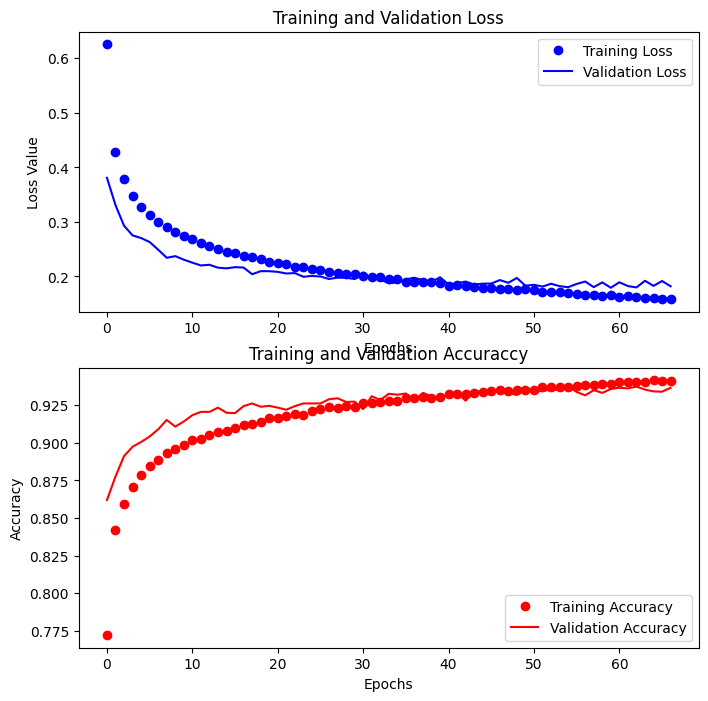

In [16]:
make_plots(history)

In [17]:
test_loss, test_acc, y_pred, y_test = test_model(model, test_loader, device)

Running test...: 100%|██████████| 157/157 [00:03<00:00, 48.71it/s]

Test Loss: 0.1704, Test Acc: 0.9420


In [18]:
# Converta y_pred e y_test para arrays NumPy
y_pred_numpy = y_pred.cpu().numpy()
y_test_numpy = y_test.cpu().numpy()

# Classification report
report = classification_report(y_test_numpy, y_pred_numpy)
print(report)

# F1-score (macro)
f1 = f1_score(y_test_numpy, y_pred_numpy, average='macro')
print(f"F1-Score (Macro): {f1:.4f}")


              precision    recall  f1-score   support

           0       0.87      0.93      0.90       500
           1       1.00      0.98      0.99       500
           2       0.93      0.92      0.92       500
           3       0.95      0.94      0.95       500
           4       0.91      0.92      0.92       500
           5       0.99      0.97      0.98       500
           6       0.84      0.81      0.82       500
           7       0.96      0.98      0.97       500
           8       0.99      0.99      0.99       500
           9       0.98      0.97      0.97       500

    accuracy                           0.94      5000
   macro avg       0.94      0.94      0.94      5000
weighted avg       0.94      0.94      0.94      5000

F1-Score (Macro): 0.9420


In [19]:
mat = confusion_matrix(y_test_numpy, y_pred_numpy)
mat

array([[467,   0,   7,   2,   1,   0,  21,   0,   2,   0],
       [  1, 492,   0,   5,   0,   0,   2,   0,   0,   0],
       [  8,   0, 459,   2,  12,   0,  19,   0,   0,   0],
       [ 11,   0,   5, 470,   5,   0,   9,   0,   0,   0],
       [  0,   0,   9,   8, 458,   0,  24,   0,   1,   0],
       [  0,   0,   0,   0,   0, 487,   0,   9,   0,   4],
       [ 48,   1,  16,   6,  25,   0, 404,   0,   0,   0],
       [  0,   0,   0,   0,   0,   1,   0, 491,   0,   8],
       [  2,   0,   0,   0,   0,   0,   1,   1, 496,   0],
       [  1,   0,   0,   0,   0,   2,   0,  11,   0, 486]])

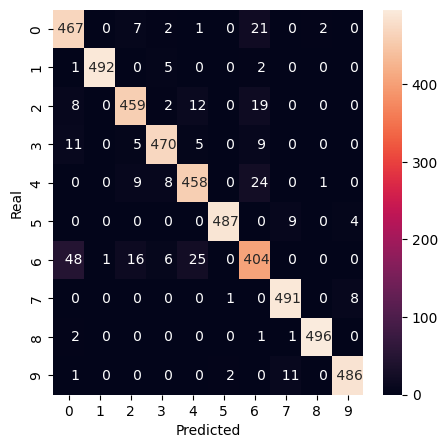

In [20]:
fig = plt.figure(figsize=(5,5))
sns.heatmap(mat, annot=True, fmt='4d')
plt.xlabel('Predicted'),plt.ylabel('Real')
plt.show()

In [21]:
torch.load('fashion_mnist_model.pt')

<ipython-input-21-69544d56d7c0>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load('fashion_mnist_model.pt')


OrderedDict([('conv1.weight',
              tensor([[[[ 3.4947e-02, -3.6188e-02,  7.2775e-03],
                        [ 2.1323e-01, -1.2789e-01, -7.9558e-02],
                        [ 2.7772e-01, -2.6782e-01, -2.7701e-02]]],
              
              
                      [[[ 2.3388e-01, -2.3172e-01, -6.7617e-03],
                        [-2.3195e-01, -4.5607e-02, -1.8022e-01],
                        [ 2.2504e-01, -3.7145e-01,  2.4808e-01]]],
              
              
                      [[[ 6.2978e-02, -2.5580e-02,  9.6375e-02],
                        [ 1.9442e-01, -3.4488e-01,  1.6592e-01],
                        [-3.5578e-02, -3.1961e-01,  2.9589e-01]]],
              
              
                      [[[-3.8257e-01,  1.8120e-01,  2.2231e-01],
                        [ 1.6885e-01,  7.0509e-02,  5.4480e-02],
                        [ 1.3232e-01, -6.9515e-02, -3.7764e-01]]],
              
              
                      [[[-2.4500e-02, -1.8617e-01,  7.0444e-02